# POPULATION MIGRATION MODEL (Urban Planning)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ygebre1/migration-flows-across-u-s-states-20102022")

print("Path to dataset files:", path)

100%|██████████| 806k/806k [00:00<00:00, 911kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ygebre1/migration-flows-across-u-s-states-20102022/versions/1


In [2]:
import os
import pandas as pd

# Define the path where kagglehub saved the data
path = '/root/.cache/kagglehub/datasets/ygebre1/migration-flows-across-u-s-states-20102022/versions/1'

# Find the csv file inside that directory
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

print(f"Loading file: {csv_file}")

# Load the data
df = pd.read_csv(full_path)

# Show the critical info
print("\n--- Data Head ---")
print(df.head())
print("\n--- Columns ---")
print(df.columns)

Loading file: migrations_2010_to_2022.csv

--- Data Head ---
  current_state  year  population  same_house  same_state  \
0       Alabama  2010     4729509     3987155      620465   
1        Alaska  2010      702974      565031       95878   
2       Arizona  2010     6332786     5069002     1001991   
3      Arkansas  2010     2888304     2387806      412997   
4    California  2010    36907897    30790221     5413287   

   from_different_state_Total  abroad_Total     from  number_of_people  
0                      108723         13166  Alabama                 0  
1                       36326          5739  Alabama               477  
2                      222725         39068  Alabama               416  
3                       79127          8374  Alabama              1405  
4                      444749        259640  Alabama              3364  

--- Columns ---
Index(['current_state', 'year', 'population', 'same_house', 'same_state',
       'from_different_state_Total', 'abroa

In [3]:
import pandas as pd
import numpy as np

# 1. Configuration
states = ['California', 'Texas', 'New York']
year = 2022

# 2. Filter data for the specific year
df_year = df[df['year'] == year].copy()

# 3. Initialize a 3x3 DataFrame for the Transition Matrix
# Rows = Origin (From), Columns = Destination (To)
flow_matrix = pd.DataFrame(0, index=states, columns=states)

# 4. Fill the Matrix
for origin in states:
    for destination in states:
        if origin == destination:
            # DIAGONAL: People who stayed (Same House + Same State)
            # We look at the destination state's row to find non-movers
            state_data = df_year[df_year['current_state'] == origin].iloc[0]
            stayed = state_data['same_house'] + state_data['same_state']
            flow_matrix.loc[origin, destination] = stayed
        else:
            # OFF-DIAGONAL: People who moved
            # Find row where 'current_state' is destination AND 'from' is origin
            try:
                flow = df_year[
                    (df_year['current_state'] == destination) &
                    (df_year['from'] == origin)
                ]['number_of_people'].values[0]
                flow_matrix.loc[origin, destination] = flow
            except IndexError:
                flow_matrix.loc[origin, destination] = 0

print("--- Raw Flow Matrix (Count of People) ---")
print(flow_matrix)

--- Raw Flow Matrix (Count of People) ---
            California     Texas  New York
California    37850263    102442     34681
Texas            42279  28766058     12233
New York         31255     30890  19034681


In [4]:
# 1. Calculate the total population we are tracking for each state (Row Sums)
row_sums = flow_matrix.sum(axis=1)

# 2. Divide each row by its total to get probabilities
# This creates our Transition Matrix 'P'
P = flow_matrix.div(row_sums, axis=0)

print("--- Transition Probability Matrix (P) ---")
print(P)

# 3. Verify that rows sum to 1 (or very close to 1 due to rounding)
print("\n--- Verification (Rows should sum to 1) ---")
print(P.sum(axis=1))

--- Transition Probability Matrix (P) ---
            California     Texas  New York
California    0.996390  0.002697  0.000913
Texas         0.001467  0.998109  0.000424
New York      0.001637  0.001618  0.996746

--- Verification (Rows should sum to 1) ---
California    1.0
Texas         1.0
New York      1.0
dtype: float64


--- First 5 Years Prediction ---
        California         Texas      New York
Year                                          
0     3.798739e+07  2.882057e+07  1.909683e+07
1     3.792380e+07  2.889939e+07  1.908160e+07
2     3.786053e+07  2.897786e+07  1.906639e+07
3     3.779758e+07  2.905600e+07  1.905121e+07
4     3.773494e+07  2.913379e+07  1.903605e+07

--- Year 50 Prediction ---
        California         Texas      New York
Year                                          
45    3.542108e+07  3.204678e+07  1.843692e+07
46    3.537041e+07  3.211151e+07  1.842286e+07
47    3.531999e+07  3.217596e+07  1.840883e+07
48    3.526983e+07  3.224012e+07  1.839483e+07
49    3.521992e+07  3.230401e+07  1.838085e+07


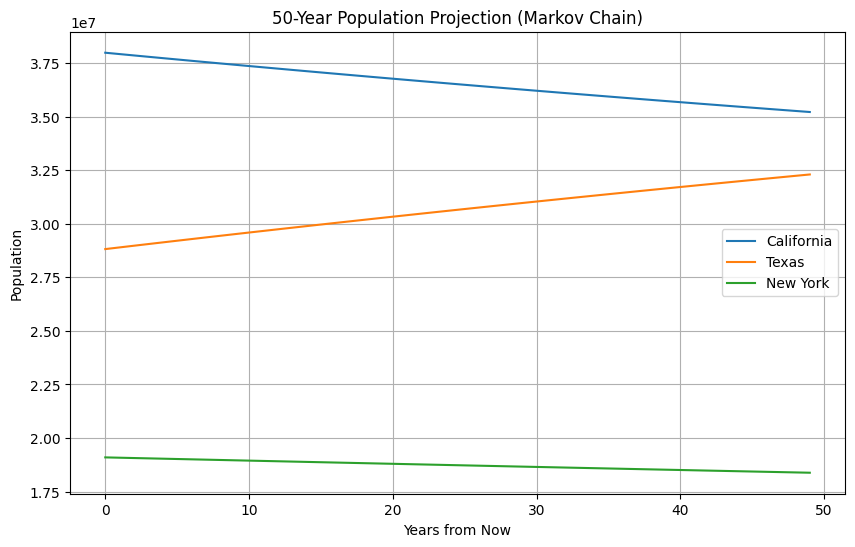

In [5]:
import matplotlib.pyplot as plt

# 1. Get the initial population (Current State Vector)
# We use the row sums from your raw data before normalization
initial_population = flow_matrix.sum(axis=1).values
current_population = initial_population.copy()

# 2. Simulation Loop (50 Years)
years_to_simulate = 50
history = []

for i in range(years_to_simulate):
    # Store current state
    history.append(current_population)

    # Calculate next year: New = Old * P
    # We use dot product for matrix multiplication
    next_population = np.dot(current_population, P.values)

    # Update for next iteration
    current_population = next_population

# 3. Create a DataFrame to view the results
df_history = pd.DataFrame(history, columns=states)
df_history.index.name = 'Year'

# Show the first 5 years and the last 5 years
print("--- First 5 Years Prediction ---")
print(df_history.head())
print("\n--- Year 50 Prediction ---")
print(df_history.tail())

# 4. Optional: Plot the trend
df_history.plot(figsize=(10, 6))
plt.title("50-Year Population Projection (Markov Chain)")
plt.ylabel("Population")
plt.xlabel("Years from Now")
plt.grid(True)
plt.show()

In [6]:
import numpy as np

# 1. Calculate Eigenvalues and Eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(P.T)

# 2. Find the index of the eigenvalue closest to 1
# In a Markov matrix, there is always one eigenvalue equal to 1
idx = np.argmin(np.abs(eigenvalues - 1))

# 3. Get the corresponding eigenvector (the Steady State)
steady_state_vector = np.real(eigenvectors[:, idx])

# 4. Normalize it so the probabilities sum to 1
steady_state_distribution = steady_state_vector / steady_state_vector.sum()

# 5. Convert to meaningful population numbers
# We multiply the steady-state percentages by the Total Population of the 3 states
total_population = current_population.sum()
steady_state_population = steady_state_distribution * total_population

# Create a readable DataFrame
df_steady = pd.DataFrame(steady_state_population, index=states, columns=['Steady State Population'])
df_steady['Share (%)'] = steady_state_distribution * 100

print("--- The Long-Term Equilibrium (Steady State) ---")
print(df_steady)

--- The Long-Term Equilibrium (Steady State) ---
            Steady State Population  Share (%)
California             2.526681e+07  29.412572
Texas                  4.737074e+07  55.143315
New York               1.326723e+07  15.444112


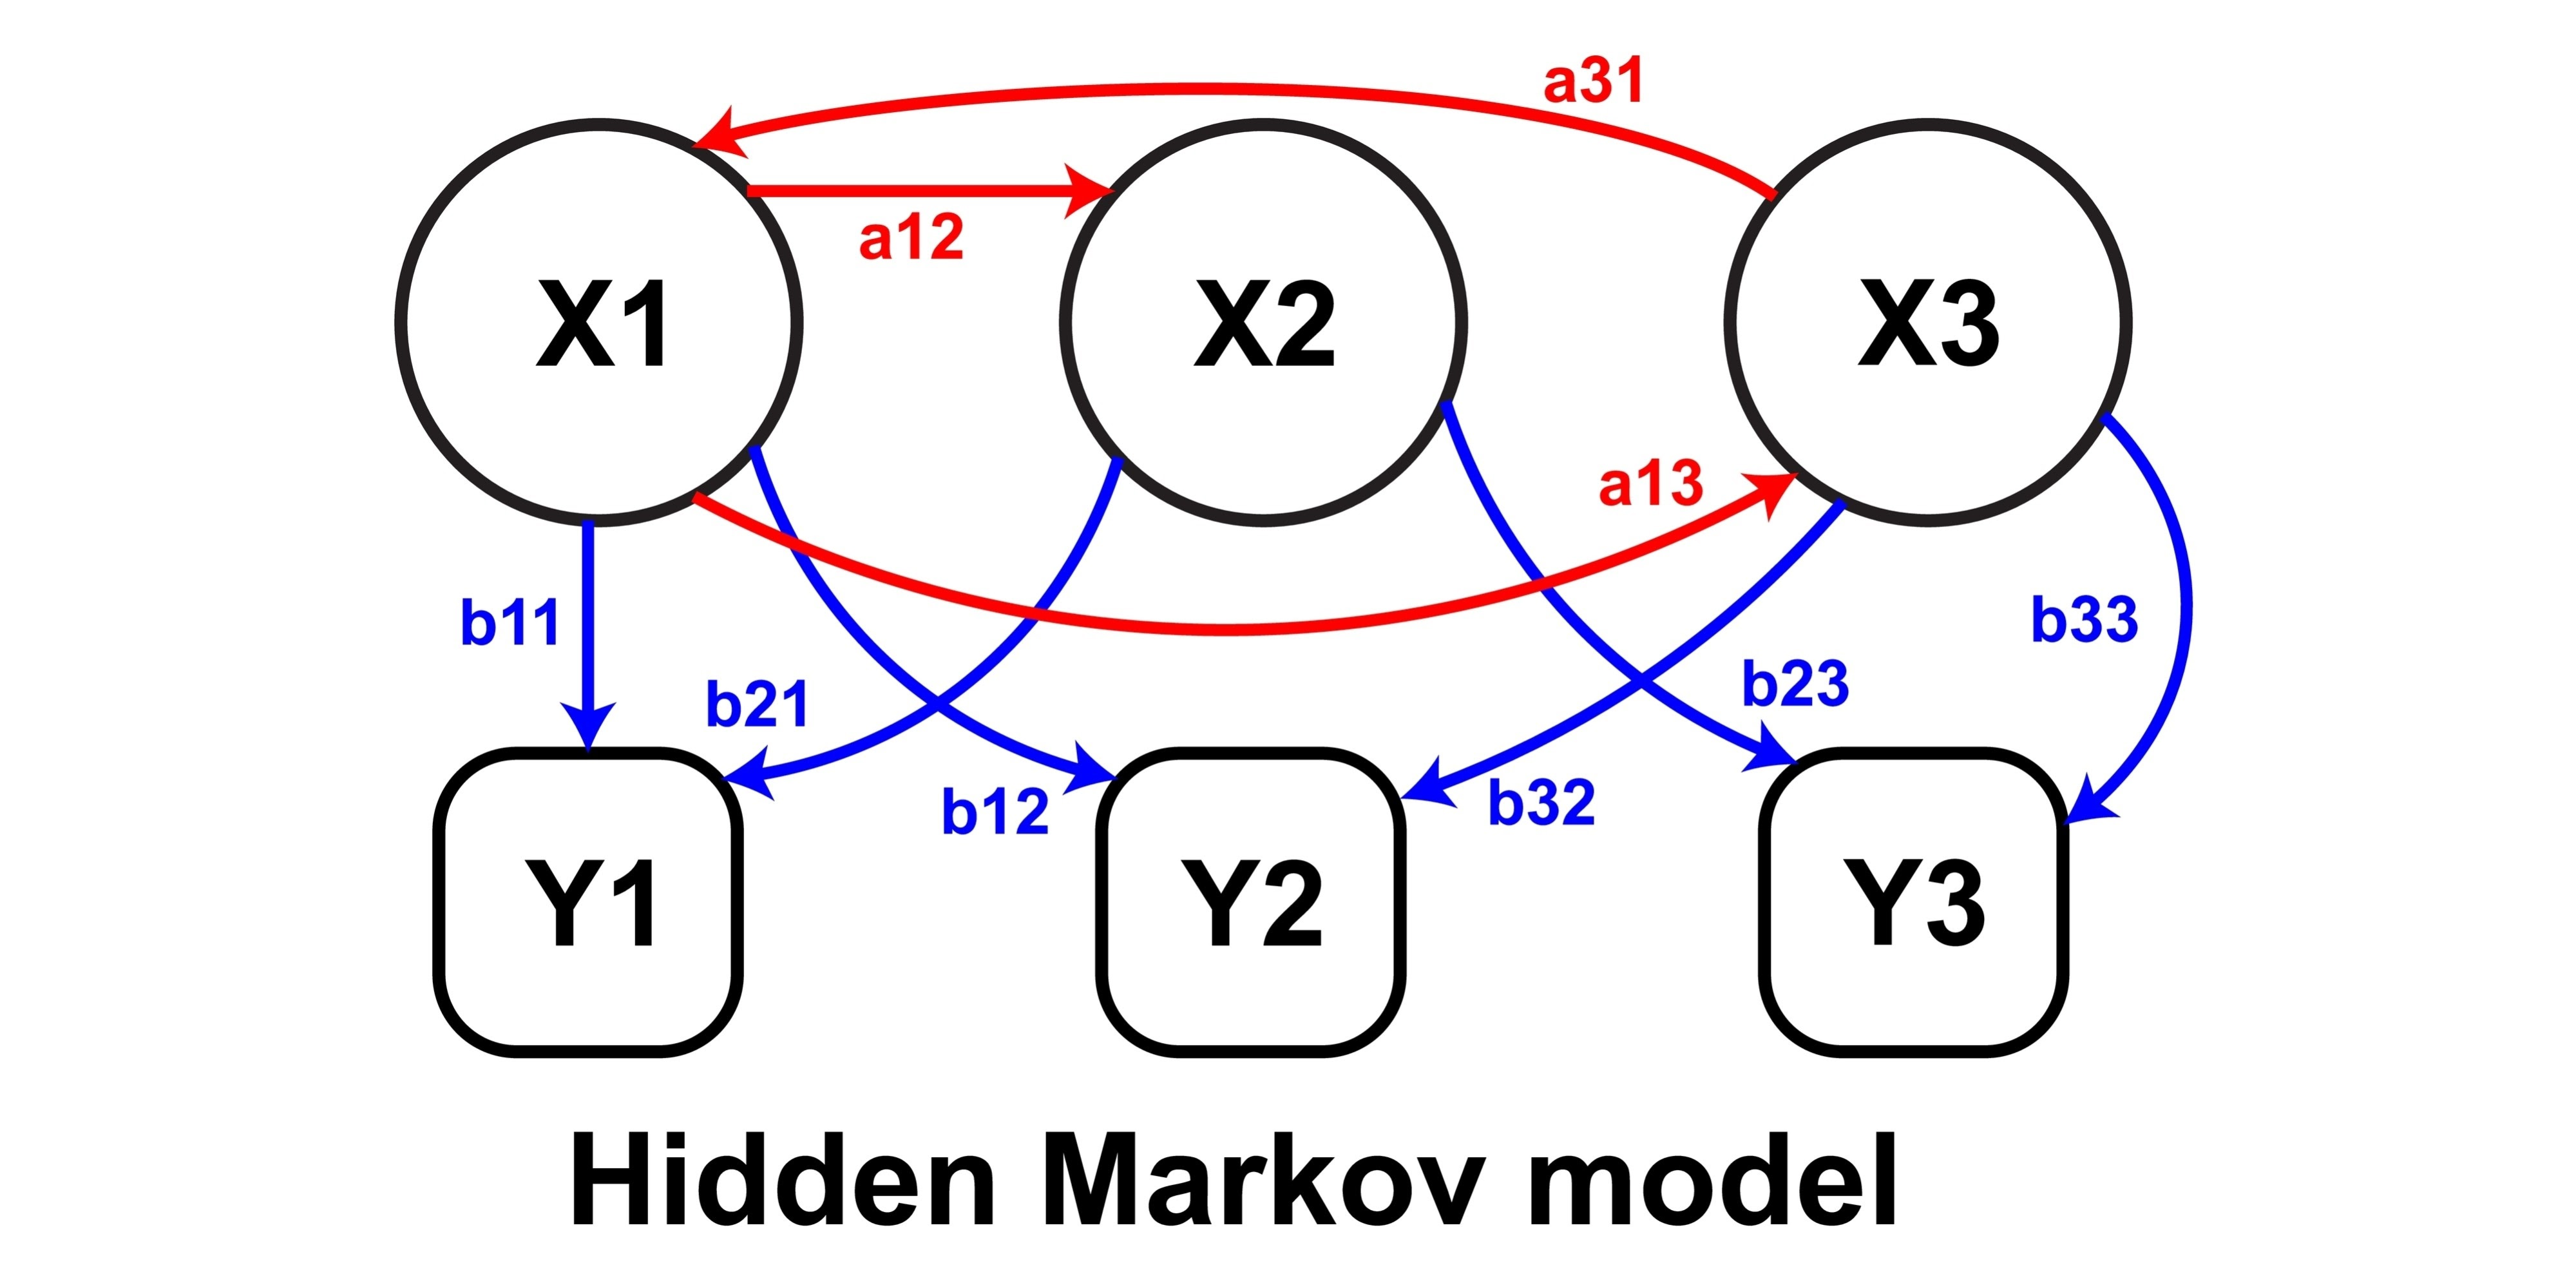

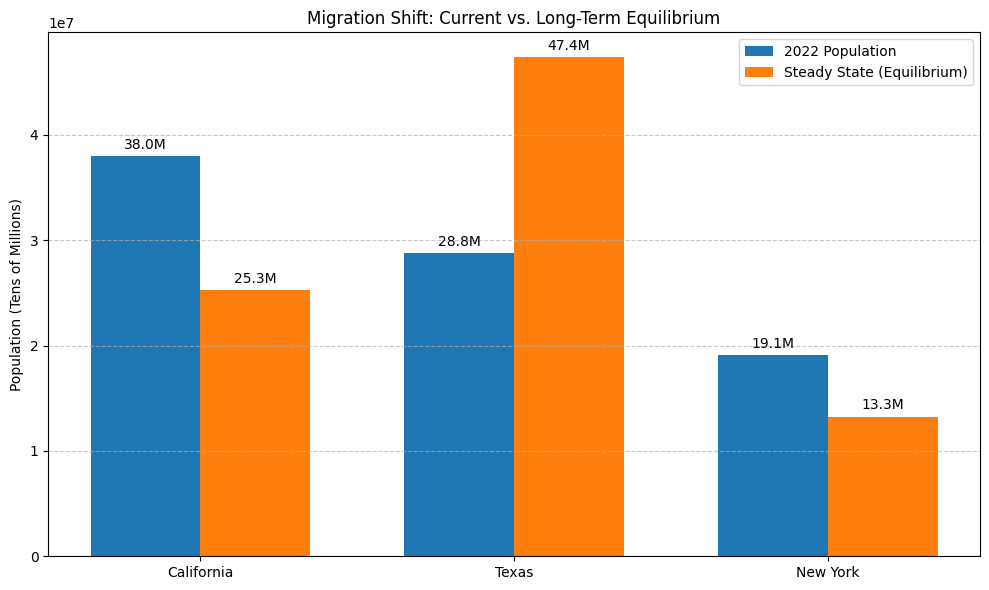

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
states = ['California', 'Texas', 'New York']
initial_pop = [37850263 + 102442 + 34681,  # Re-calculating totals from your raw data for accuracy
               42279 + 28766058 + 12233,
               31255 + 30890 + 19034681]

# Use the steady state numbers you just calculated
steady_pop = [2.526681e+07, 4.737074e+07, 1.326723e+07]

# Plotting
x = np.arange(len(states))
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create side-by-side bars
rects1 = ax.bar(x - width/2, initial_pop, width, label='2022 Population', color='#1f77b4')
rects2 = ax.bar(x + width/2, steady_pop, width, label='Steady State (Equilibrium)', color='#ff7f0e')

# Labels and Styling
ax.set_ylabel('Population (Tens of Millions)')
ax.set_title('Migration Shift: Current vs. Long-Term Equilibrium')
ax.set_xticks(x)
ax.set_xticklabels(states)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height/1e6:.1f}M',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

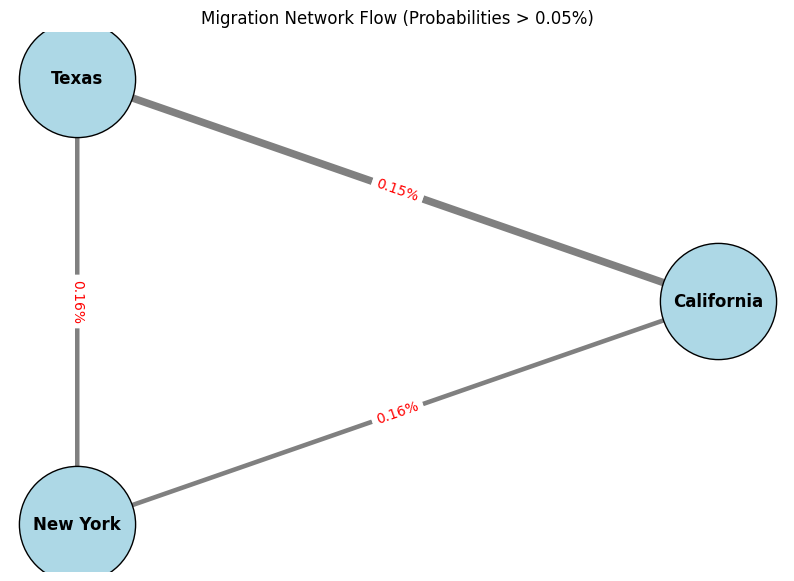

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create a directed graph
G = nx.DiGraph()

# 2. Add nodes (States)
states = ['California', 'Texas', 'New York']
G.add_nodes_from(states)

# 3. Add edges (Transitions)
# We only add edges for significant migration flow to keep the chart clean
# (probabilities > 0.0005, i.e., > 0.05%)
for origin in states:
    for destination in states:
        if origin != destination: # Don't draw the self-loops for clarity
            prob = P.loc[origin, destination]
            if prob > 0.0005:
                # Weight controls the thickness of the line
                G.add_edge(origin, destination, weight=prob, label=f"{prob:.2%}")

# 4. Draw the Graph
plt.figure(figsize=(10, 7))
pos = nx.circular_layout(G)  # Arrange nodes in a circle

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='lightblue', edgecolors='black')

# Draw edges (arrows)
edges = G.edges()
weights = [G[u][v]['weight'] * 2000 for u, v in edges] # Make lines thicker based on flow
nx.draw_networkx_edges(G, pos, width=weights, arrowstyle='->', arrowsize=20, edge_color='gray')

# Draw Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw Edge Labels (Percentages)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Migration Network Flow (Probabilities > 0.05%)")
plt.axis('off') # Hide the axis
plt.show()

In [9]:
# Create a dictionary of your dataframes
outputs = {
    'migration_counts_raw.csv': flow_matrix,
    'transition_matrix.csv': P,
    '50_year_forecast.csv': df_history,
    'steady_state.csv': df_steady
}

print("--- Saving Files ---")

# Loop through and save each one
for filename, dataframe in outputs.items():
    dataframe.to_csv(filename)
    print(f"Saved: {filename}")

print("\nAll files are ready! Check your file browser on the left.")

--- Saving Files ---
Saved: migration_counts_raw.csv
Saved: transition_matrix.csv
Saved: 50_year_forecast.csv
Saved: steady_state.csv

All files are ready! Check your file browser on the left.
